In [180]:
import numpy as np
import pandas as pd
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [181]:
# Define main path to dataset
main_path = '/kaggle/input/d/xhlulu/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')


In [182]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


In [183]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [184]:
images_df = pd.DataFrame(images_df)

In [185]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

In [186]:
real_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

In [187]:
fake_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

In [188]:
# Data Augmentation
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
    zoom_range=0.3,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)


image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [189]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


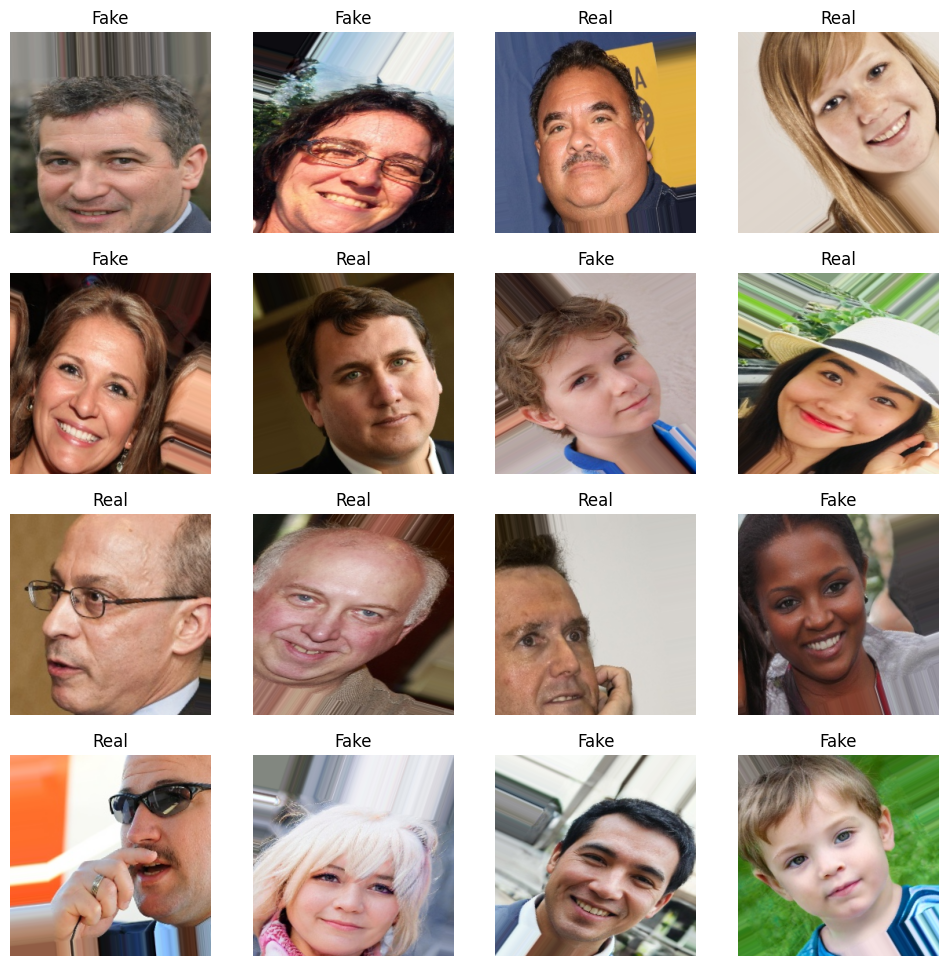

In [190]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if label[i] == 0:
            plt.title("Fake")
        else:
            plt.title("Real")
img,lbl = next(train_ds)
plot_images(img,lbl)

In [191]:
for img, label in train_ds:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Values:  [[[0.45113352 0.3637677  0.22201724]
  [0.6312885  0.54619217 0.38855472]
  [0.7390839  0.6492451  0.47562438]
  ...
  [0.6392157  0.5882353  0.5568628 ]
  [0.6392157  0.5882353  0.5568628 ]
  [0.6392157  0.5882353  0.5568628 ]]

 [[0.63024914 0.5459511  0.38495913]
  [0.643842   0.56060404 0.38867047]
  [0.606074   0.51732695 0.34043074]
  ...
  [0.6392157  0.5882353  0.5568628 ]
  [0.6392157  0.5882353  0.5568628 ]
  [0.6392157  0.5882353  0.5568628 ]]

 [[0.6382932  0.5562986  0.37791577]
  [0.58710694 0.5046806  0.32098445]
  [0.5871873  0.5009128  0.31659907]
  ...
  [0.6392157  0.5882353  0.5568628 ]
  [0.6392157  0.5882353  0.5568628 ]
  [0.6392157  0.5882353  0.5568628 ]]

 ...

 [[0.9844696  0.8657751  0.644964  ]
  [0.9774487  0.84607154 0.6107682 ]
  [0.966497   0.82983917 0.600597  ]
  ...
  [0.16078432 0.21960786 0.24705884]
  [0.16056146 0.21938498 0.24683598]
  [0.1599619  0.21878542 0.2462364 ]]

 [[0.9828069  0.86134124 0.6394216 ]
  [0.9768945  0.84440887 0.6

In [192]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(64, 256, 256, 3)
(64,)


In [193]:
train_ds.class_indices

{'fake': 0, 'real': 1}

In [194]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [195]:
# Assuming the uploaded weights file is located in '/kaggle/input/efficientnetb0-weights'
local_weights_path = '/kaggle/input/weights/efficientnetb0_notop.h5'

In [196]:
# Load EfficientNetB0 model with local weights and include_top=False
efficientnet_b0 = EfficientNetB0(weights=local_weights_path, include_top=False, input_shape=(256, 256, 3))

In [197]:
# Make EfficientNetB0 layers trainable
efficientnet_b0.trainable = True

In [198]:
# Increase regularization in the model
custom_cnn = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),  # Increased regularization
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.5),  # Increased dropout

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),  # Increased regularization
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.5),  # Increased dropout

    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),  # Increased regularization
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.5),  # Increased dropout

    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),  # Increased regularization
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.5),  # Increased dropout

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),  # Increased regularization
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout
])


In [199]:
# Add the custom CNN architecture to EfficientNetB0
x = efficientnet_b0.output
x = custom_cnn(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)  # Batch Normalization Layer
x = Dropout(0.5)(x)  # Dropout Layer
x = Dense(1, activation='sigmoid')(x)

# Create the hybrid model
hybrid_model = Model(inputs=efficientnet_b0.input, outputs=x)

In [200]:
# Compile the model with a higher learning rate
# Compile the model with a lower learning rate
hybrid_model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
                     loss='binary_crossentropy',
                     metrics=['accuracy'])


# Summary of the hybrid model
hybrid_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 256, 256,  │          0 │ input_layer_12[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_6     │ (None, 256, 256,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ normalization_6[… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 128, 128,  │         64 │ block1a_project_

 Total params: 6,737,252 (25.70 MB)

 Trainable params: 6,691,773 (25.53 MB)

 Non-trainable params: 45,479 (177.66 KB)

In [201]:
checkpoint_filepath = "model_cp.weights.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True
)

In [202]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=3,
                                                     restore_best_weights=True,
                                                    )

In [203]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

In [204]:
# Train the model with fewer epochs
history = hybrid_model.fit(train_ds,
                           epochs=10,  # Fewer epochs
                           validation_data=valid_ds,
                           callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr])


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2130s 1s/step - accuracy: 0.5264 - loss: 10.1371 - val_accuracy: 0.7060 - val_loss: 6.6280 - learning_rate: 1.0000e-04
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1980s 1s/step - accuracy: 0.8787 - loss: 5.2814 - val_accuracy: 0.9020 - val_loss: 2.9432 - learning_rate: 1.0000e-04
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1974s 1s/step - accuracy: 0.9517 - loss: 2.2239 - val_accuracy: 0.9315 - val_loss: 1.0857 - learning_rate: 1.0000e-04
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2036s 1s/step - accuracy: 0.9681 - loss: 0.7825 - val_accuracy: 0.9779 - val_loss: 0.3569 - learning_rate: 1.0000e-04
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1991s 1s/step - accuracy: 0.9773 - loss: 0.2980 - val_accuracy: 0.9875 - val_loss: 0.1529 - learning_rate: 1.0000e-04
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1999s 1s/step - accuracy: 0.9828 - loss: 0.1560 - val_accuracy: 0.9937 - val_loss: 0.0912 - learning_rate: 1.0000e-04
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2043s 1s

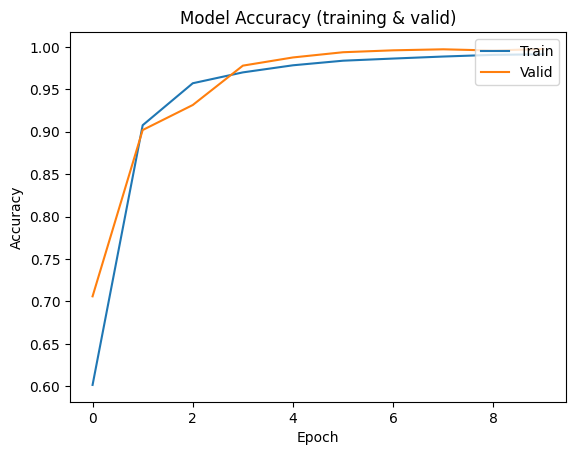

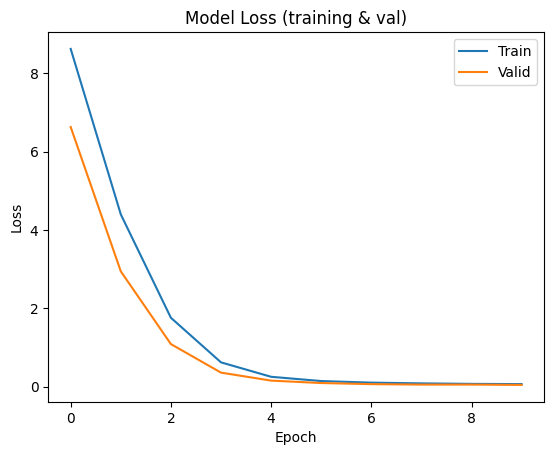

In [205]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [206]:
# Evaluate the model on the test set
test_loss, test_acc = hybrid_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 152s 486ms/step - accuracy: 0.9973 - loss: 0.0402
Test Loss: 0.044066015630960464
Test Accuracy: 0.996749997138977


In [207]:
# Save the model
hybrid_model.save('hybrid_deepfake_detection_model.keras')